In [2]:
import os
import pandas as pd
import numpy as np
from Bio.Phylo.TreeConstruction import DistanceCalculator
from Bio import AlignIO
from Bio.SeqRecord import SeqRecord
import numpy as np
from Bio import AlignIO
from sklearn.preprocessing import OneHotEncoder
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from adjustText import adjust_text

In [3]:
os.chdir("/mnt/d/Analysis/20240923/")

In [8]:
def phasing(alignment_file):
    aln = AlignIO.read(alignment_file, 'fasta')
    calculator = DistanceCalculator('identity')
    dm = calculator.get_distance(aln)
    #Convert to dataframe
    df = pd.DataFrame(dm.matrix)
    #Fill the NaN based on the matrix diagonal
    for i in range(len(df.columns)):
        for j in range(len(df.columns)):
            if i == j:
                df.iloc[i, j] = 0
            else:
                df.iloc[i, j] = df.iloc[j, i]

    df.columns = [record.id for record in aln]
    df.index = [record.id for record in aln]

#----------------------------After hae the distance matrix, we can start to phase the sequences
    sequence_dict = []
    isolate_list = []
    sequence_list = []
    ref_list = []
    for sequence in aln:
        sequence_list.append(sequence.id)
    for sequence in aln:
        isolate_name = sequence.id.split("_")[1]
        if isolate_name not in isolate_list:
            isolate_list.append(isolate_name)
        if "ref" in sequence.id:
            ref_list.append(sequence.id)
    #print(isolate_list)
    for name in isolate_list:
        if "ref" in name:
            #search name in sequence_list
            match1 = [s for s in sequence_list if name in s and 'hapA' in s]
            match2 = [s for s in sequence_list if name in s and 'hapB' in s]
            sequence_dict.append([match1[0], match2[0]])
        else:
            match = [s for s in sequence_list if name in s and 'ref' not in s]
            tmp_df = df.loc[ref_list, match]
            min_distance1_name = tmp_df[match[0]].idxmin()
            min_distance1 = tmp_df[match[0]].min()
            min_distance2_name = tmp_df[match[1]].idxmin()
            min_distance2 = tmp_df[match[1]].min()
            if len(match) > 1:
                if min_distance1 == min_distance2:
                    #If the distance is the same
                    tmp_hap1 = min_distance1_name.split("_")[2]
                    tmp_hap2 = min_distance2_name.split("_")[2]
                    if tmp_hap1 != tmp_hap2:
                        if tmp_hap1 == "hapA":
                            sequence_dict.append([match[0], match[1]])
                        else:
                            sequence_dict.append([match[1], match[0]])
                    elif tmp_hap1 == tmp_hap2 == "hapA":
                         sequence_dict.append([match[0], match[1]])
                    else:
                        sequence_dict.append([match[1], match[0]])
                elif min_distance1 < min_distance2:
                    tmp_hap1 = min_distance1_name.split("_")[2]
                    if tmp_hap1 == "hapA":
                            sequence_dict.append([match[0], match[1]])
                    else:
                            sequence_dict.append([match[1], match[0]])
                elif min_distance1 > min_distance2:
                    tmp_hap2 = min_distance2_name.split("_")[2]
                    if tmp_hap2 == "hapA":
                            sequence_dict.append([match[1], match[0]])
                    else:
                            sequence_dict.append([match[0], match[1]])
    
    #Concentrate the sequences
    sequence_dict2 ={}
    for i in range(len(sequence_dict)):
        isolate_name = sequence_dict[i][0].split("_")[1]
        sequence_dict2[isolate_name] = [sequence_dict[i][0], sequence_dict[i][1]]
    con_aln = []

    for key in sequence_dict2.items():
        isolate_name = key[0]
        seq1 = [s for s in aln if key[1][0] in s.id]
        seq2 = [s for s in aln if key[1][1] in s.id]
        seq1_seq = seq1[0].seq
        seq2_seq = seq2[0].seq
        concatenated_seq = seq1_seq + seq2_seq
        con_aln.append(SeqRecord(seq=concatenated_seq, id=isolate_name))

    return con_aln,sequence_dict2

In [27]:
def one_hot_encoding(alignment, title, save_path):
    max_categories = 4
    categories = ['A', 'T', 'C', 'G']
    # Check for gaps in the alignment
    for sequence in alignment:
        if '-' in sequence.seq:
            max_categories = 5
            categories = ['A', 'T', 'C', 'G', '-']
            break
    id_list = []
    combined_array = np.array([])
    for sequence in alignment:
        seq = sequence.seq
        id_list.append(sequence.id)
        # Convert seq to np.array
        X = np.array(list(str(seq))).reshape(-1, 1)
        ohe = OneHotEncoder(categories=[categories], sparse_output=False).fit(X)
        seq_array = ohe.transform(X)
        # Flatten the array
        seq_array = seq_array.flatten()
        # Combine the array
        if combined_array.size == 0:
            combined_array = seq_array
        else:
            combined_array = np.vstack((combined_array, seq_array))
    pca = PCA(n_components=2)
    pca_result = pca.fit_transform(combined_array)
    #convert to dataframe
    pca_df = pd.DataFrame(pca_result, columns=["PC1", "PC2"])
    pca_df["isolate"] = id_list
    #Plot the PCA
    fig, ax = plt.subplots()

    # Plot the points
    ax.scatter(pca_df["PC1"], pca_df["PC2"], s = 10)

    # Create a list to store the text annotations
    texts = []

    # Annotate the points
    for i, txt in enumerate(pca_df["isolate"]):
        texts.append(ax.annotate(txt, (pca_df["PC1"][i], pca_df["PC2"][i])))

    # Adjust the text annotations to avoid overlaps
    adjust_text(texts, arrowprops=dict(arrowstyle='->', color='black'))
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.title(title)
    plt.show()
    #Save as svg
    fig.savefig(save_path, format='svg')
    return

In [9]:
og4974_aln, og4974_aln_dict = phasing("OG4974.fasta")
og7530_1_aln, og7530_1_aln_dict = phasing("OG7530_1.fasta")
og7530_2_aln, og7530_2_aln_dict = phasing("OG7530_2.fasta")
og9632_aln, og9632_aln_dict = phasing("OG9632.fasta")
og9774_aln, og9774_aln_dict = phasing("OG9774.fasta")

In [15]:
og9774_aln_dict

{'GM1(ref)': ['OG9774-5_GM1(ref)_hapA', 'OG9774-6_GM1(ref)_hapB'],
 'JM3': ['OG9774-5_JM3', 'OG9774-6_JM3'],
 'GM1': ['OG9774-5_GM1', 'OG9774-6_GM1'],
 'CA': ['OG9774-1*_CA', 'OG9774-4_CA'],
 'JM1': ['OG9774-3_JM1', 'OG9774-4_JM1'],
 'CG': ['OG9774-4_CG', 'OG9774-4*_CG'],
 'JM4': ['OG9774-3_JM4', 'OG9774-4_JM4'],
 '4.1': ['OG9774-3_4.1', 'OG9774-4_4.1'],
 'JRM1': ['OG9774-3_JRM1', 'OG9774-4_JRM1'],
 'MF1': ['OG9774-3_MF1', 'OG9774-4_MF1'],
 'JM1(ref)': ['OG9774-3_JM1(ref)_hapA', 'OG9774-4_JM1(ref)_hapB'],
 'MF1(ref)': ['OG9774-3_MF1(ref)_hapA', 'OG9774-4_MF1(ref)_hapB'],
 '3.1': ['OG9774-1*_3.1', 'OG9774-2_3.1'],
 'SYD': ['OG9774-1_SYD', 'OG9774-2_SYD'],
 'Au3(ref)': ['OG9774-1_Au3(ref)_hapA', 'OG9774-2_Au3(ref)_hapB'],
 'AU3': ['OG9774-1_AU3', 'OG9774-2_AU3']}

In [7]:
og4974_aln

[SeqRecord(seq=Seq('CAACAGCAACCGTCTCAACAGCAGCAACAGCCACAGCAGCAGCCAATTTATCAT...CCG'), id='GM1(ref)', name='<unknown name>', description='<unknown description>', dbxrefs=[]),
 SeqRecord(seq=Seq('CAACAGCAACCGTCTCAACAGCAGCAACAGCCACAGCAGCAGCCAATTTATCAT...CCG'), id='GM1', name='<unknown name>', description='<unknown description>', dbxrefs=[]),
 SeqRecord(seq=Seq('CAACAGCAACCGTCTCAACAGCAGCAACAGCCACAGCAGCAGCCAATTTATCAT...CCG'), id='CG', name='<unknown name>', description='<unknown description>', dbxrefs=[]),
 SeqRecord(seq=Seq('CAACAGCAACCGTCTCAACAGCAGCAACAGCCACAGCAGCAGCCAATTTATCAT...CCG'), id='MF1(ref)', name='<unknown name>', description='<unknown description>', dbxrefs=[]),
 SeqRecord(seq=Seq('CAACAGCAACCGTCTCAACAGCAGCAACAGCCACAGCAGCAGCCAATTTATCAT...CCG'), id='JM1(ref)', name='<unknown name>', description='<unknown description>', dbxrefs=[]),
 SeqRecord(seq=Seq('CAACAGCAACCGTCTCAACAGCAGCAACAGCCACAGCAGCAGCCAATTTATCAT...CCG'), id='MF1', name='<unknown name>', description='<unknown description>

In [16]:
isolate_list = []
for sequence in og4974_aln:
    isolate_list.append(sequence.id)

In [17]:
og1_list = ['og4974', 'og7530_1', 'og9632', 'og9774']
og2_list = ['og4974', 'og7530_2', 'og9632', 'og9774']

In [20]:
merged_aln1 = []
for isolate in isolate_list:
    tmp_seq = ""
    for og in og1_list:
        og_aln = phasing(f"{og}.fasta")[0]
        for sequence in og_aln:
            if sequence.id == isolate:
                tmp_seq = tmp_seq + sequence.seq
    merged_aln1.append(SeqRecord(seq=tmp_seq, id=isolate))
merged_aln2 = []
for isolate in isolate_list:
    tmp_seq = ""
    for og in og2_list:
        og_aln = phasing(f"{og}.fasta")[0]
        for sequence in og_aln:
            if sequence.id == isolate:
                tmp_seq = tmp_seq + sequence.seq
    merged_aln2.append(SeqRecord(seq=tmp_seq, id=isolate))

In [91]:
#Save the merged alignment
with open("merged_alignment.fasta", "w") as output_handle:
    for record in merged_aln:
        #write header
        output_handle.write(f">{record.id}\n")
        #write sequence
        output_handle.write(f"{record.seq}\n")

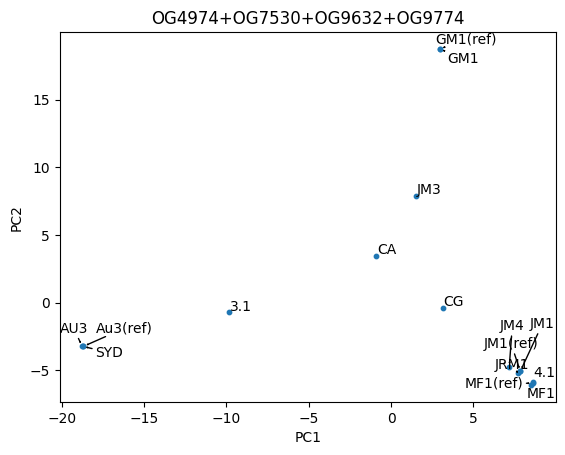

In [28]:
one_hot_encoding(merged_aln1, "OG4974+OG7530+OG9632+OG9774", "merged_aln1_pca.svg")

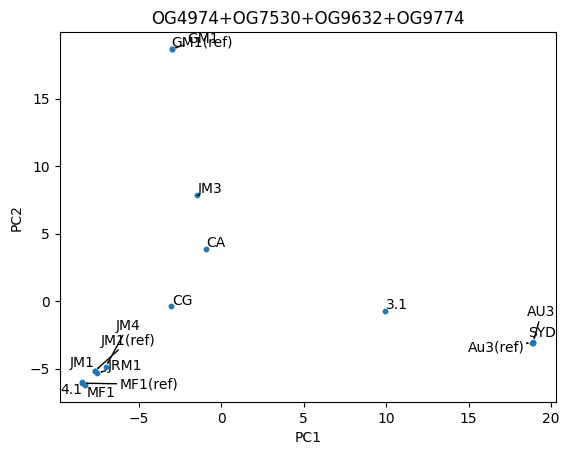

In [29]:
one_hot_encoding(merged_aln2, "OG4974+OG7530+OG9632+OG9774", "merged_aln2_pca.svg")

In [98]:
bW_aln = phasing("bW-HD_ref.fasta")
bE_aln = phasing("bE-HD_ref.fasta")

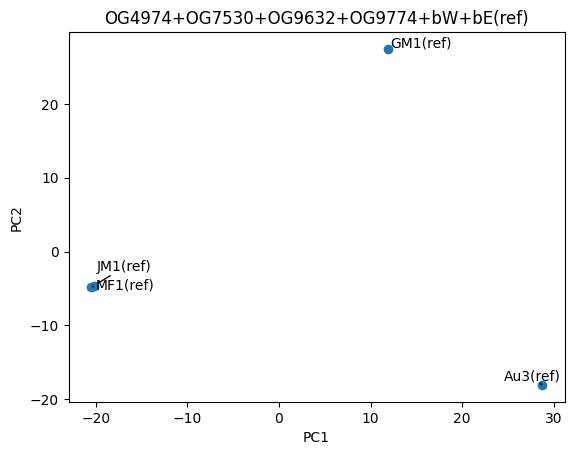

In [121]:
merged_aln_ref = []
og_list = ['og4974', 'og7530', 'og9632', 'og9774']
merged_aln = []
for isolate in isolate_list:
    tmp_seq = ""
    for og in og_list:
        og_aln = phasing(f"{og}.fasta")
        for sequence in og_aln:
            if sequence.id == isolate:
                tmp_seq = tmp_seq + sequence.seq
    merged_aln.append(SeqRecord(seq=tmp_seq, id=isolate))

for sequence in merged_aln:
    if "ref" in sequence.id:
        merged_aln_ref.append(sequence)
joined_aln_ref = []
for sequence in merged_aln_ref:
    for bW in bW_aln:
        if sequence.id == bW.id:
            sequence.seq = sequence.seq + bW.seq
    for bE in bE_aln:
        if sequence.id == bE.id:
            sequence.seq = sequence.seq + bE.seq
    joined_aln_ref.append(SeqRecord(seq=sequence.seq, id=sequence.id))
one_hot_encoding(joined_aln_ref, "OG4974+OG7530+OG9632+OG9774+bW+bE(ref)")

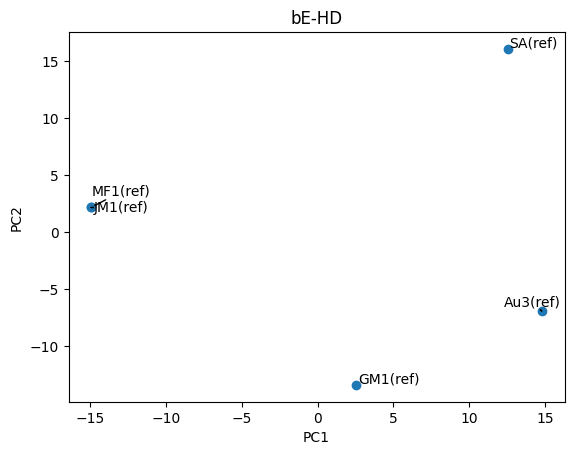

In [100]:
one_hot_encoding(bE_aln, "bE-HD")

In [122]:
merged_aln_ref

[SeqRecord(seq=Seq('CAACAGCAACCGTCTCAACAGCAGCAACAGCCACAGCAGCAGCCAATTTATCAT...TGA'), id='GM1(ref)', name='<unknown name>', description='<unknown description>', dbxrefs=[]),
 SeqRecord(seq=Seq('CAACAGCAACCGTCTCAACAGCAGCAACAGCCACAGCAGCAGCCAATTTATCAT...TGA'), id='MF1(ref)', name='<unknown name>', description='<unknown description>', dbxrefs=[]),
 SeqRecord(seq=Seq('CAACAGCAACCGTCTCAACAGCAGCAACAGCCACAGCAGCAGCCAATTTATCAT...TGA'), id='JM1(ref)', name='<unknown name>', description='<unknown description>', dbxrefs=[]),
 SeqRecord(seq=Seq('CAACAGCAACCGTCTCAACAGCAGCAACAGCCACAGCAGCAGCCAATTTATCAT...TGA'), id='Au3(ref)', name='<unknown name>', description='<unknown description>', dbxrefs=[])]

In [123]:
position_variants = []
for position in range(len(merged_aln_ref[0].seq)):
    base = []
    for sequence in merged_aln_ref:
        base.append(sequence.seq[position])
    if len(set(base)) > 1:
        position_variants.append(position)

In [124]:
#Only keep the variable positions
merged_aln_ref_var = []
for sequence in merged_aln_ref:
    tmp_seq = ""
    for position in position_variants:
        tmp_seq = tmp_seq + sequence.seq[position]
    merged_aln_ref_var.append(SeqRecord(seq=tmp_seq, id=sequence.id))

/home/jylin/biopy/lib/python3.10/site-packages/Bio/SeqRecord.py:229: BiopythonDeprecationWarning: Using a string as the sequence is deprecated and will raise a TypeError in future. It has been converted to a Seq object.
  warnings.warn(


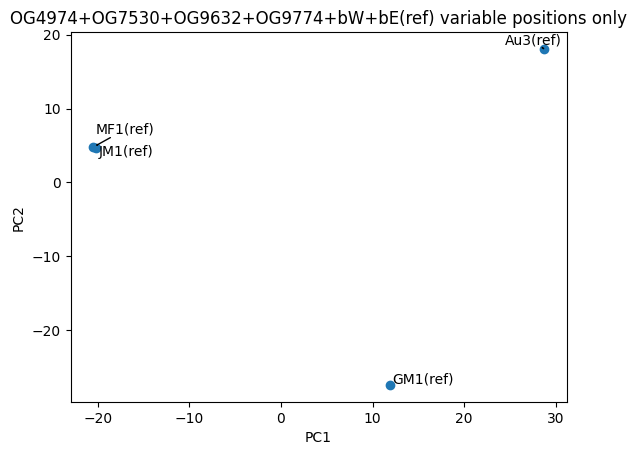

In [125]:
one_hot_encoding(merged_aln_ref_var, "OG4974+OG7530+OG9632+OG9774+bW+bE(ref) variable positions only")